# **Digits**

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from google.colab import drive

In [2]:
%matplotlib inline

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Image Acquisition**

In [4]:
import keras
from keras.datasets import mnist

In [5]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

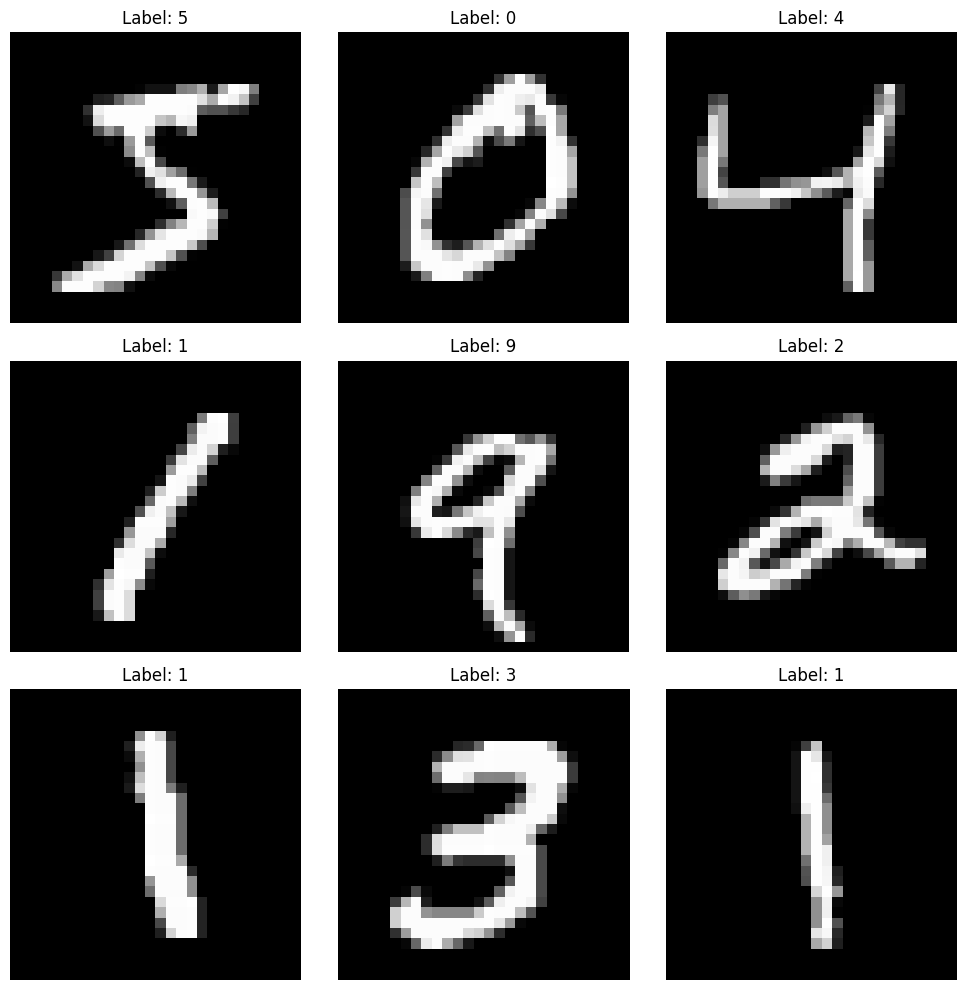

In [6]:
# Visualize the first few images in the dataset
def visualize_images(images, labels, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_images(train_X, train_y)

# **Image Enhancement**

In [7]:
def visualize_pipeline(img, label):

    # Ensure the image is grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 1: Original Image
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 6, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\nLabel: {label}")
    plt.axis('off')

In [8]:
def enhance_image(img):
    # Histogram Equalization
    img_eq = cv2.equalizeHist(img)
    # Morphological Operations
    kernel = np.ones((3, 3), np.uint8)
    img_morph = cv2.morphologyEx(img_eq, cv2.MORPH_CLOSE, kernel)
    # Sharpening
    img_sharp = cv2.filter2D(img_morph, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
    return img_eq, img_morph, img_sharp

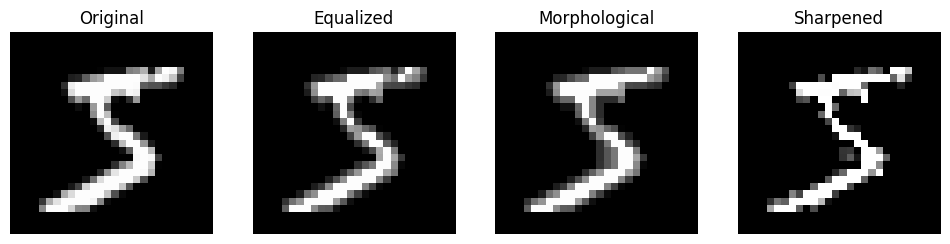

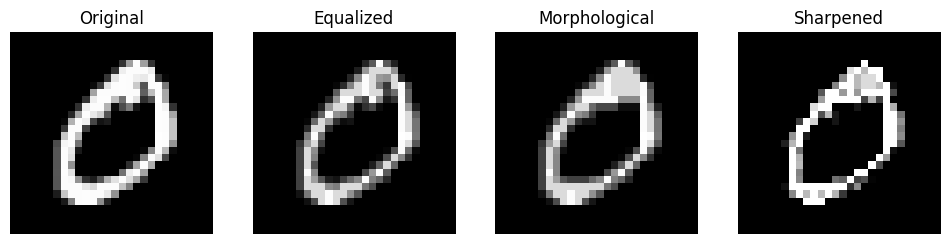

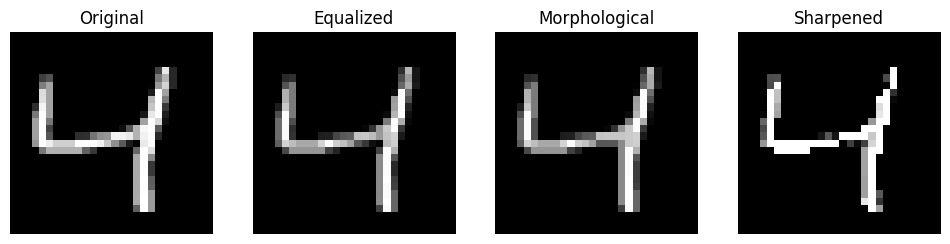

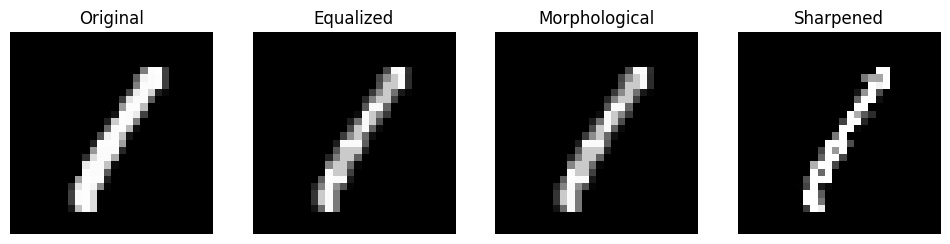

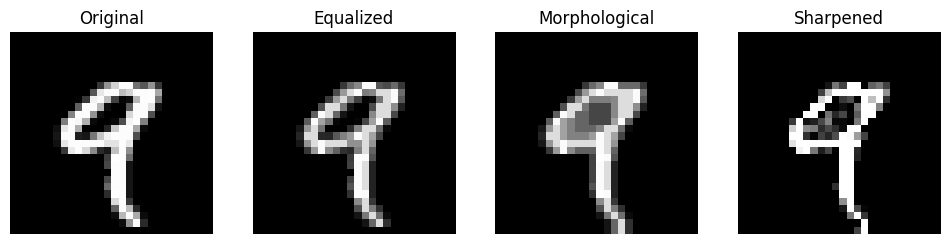

In [10]:
enhanced_train_X = []
for i, img in enumerate(train_X[:5]):  # Only show for first 5 images for brevity
    img_eq, img_morph, img_sharp = enhance_image(img)
    enhanced_train_X.append((img_eq, img_morph, img_sharp))
    # Display original and enhanced images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(img_eq, cmap='gray')
    plt.title("Equalized")
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(img_morph, cmap='gray')
    plt.title("Morphological")
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(img_sharp, cmap='gray')
    plt.title("Sharpened")
    plt.axis('off')
    plt.show()


# **Image Restoration**

In [11]:
def restore_image(img):
    # Bilateral Filtering
    img_bilateral = cv2.bilateralFilter(img, 9, 75, 75)
    # Gaussian Filtering
    img_denoised = cv2.GaussianBlur(img_bilateral, (5, 5), 0)
    # Median Filtering
    img_median = cv2.medianBlur(img_denoised, 5)
    # Adaptive Thresholding
    img_binarized = cv2.adaptiveThreshold(
        img_median, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return img_bilateral, img_denoised, img_median, img_binarized

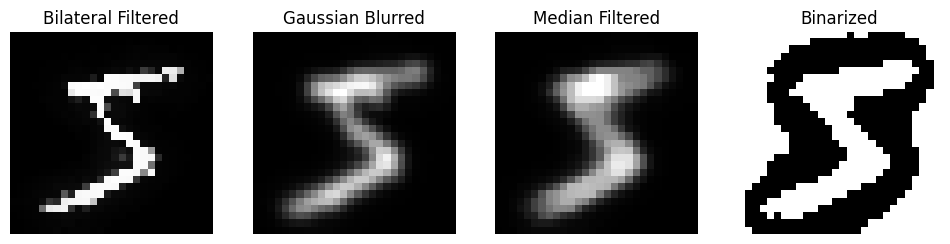

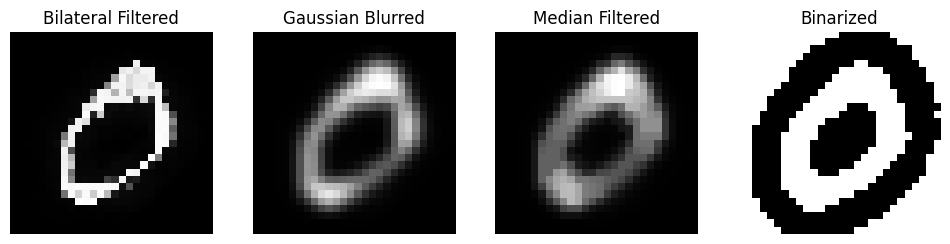

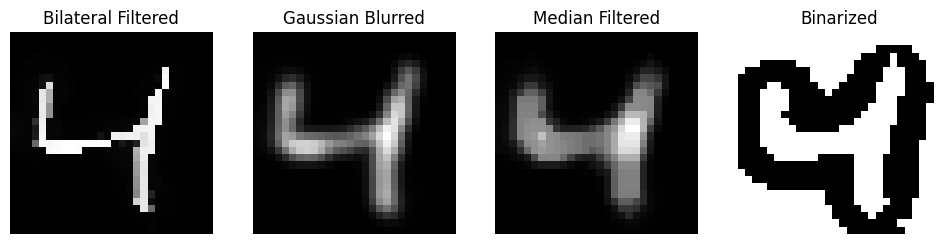

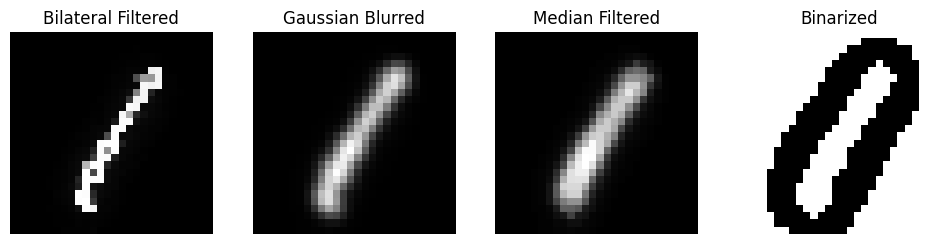

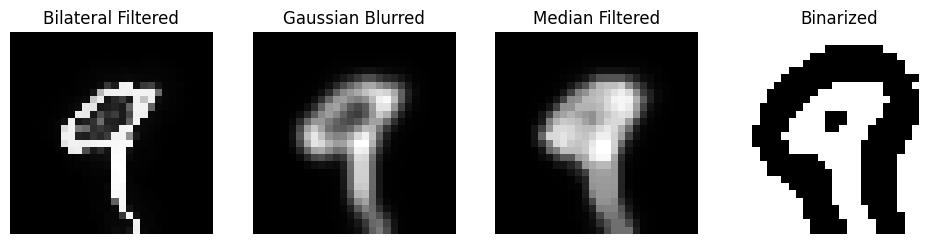

In [12]:
restored_train_X = []
for i, (_, _, img_sharp) in enumerate(enhanced_train_X[:5]):  # For first 5 images
    img_bilateral, img_denoised, img_median, img_binarized = restore_image(img_sharp)
    restored_train_X.append((img_bilateral, img_denoised, img_median, img_binarized))
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(img_bilateral, cmap='gray')
    plt.title("Bilateral Filtered")
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(img_denoised, cmap='gray')
    plt.title("Gaussian Blurred")
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(img_median, cmap='gray')
    plt.title("Median Filtered")
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(img_binarized, cmap='gray')
    plt.title("Binarized")
    plt.axis('off')
    plt.show()

# **Image Segmentation**

In [19]:
# Image Segmentation
def segment_characters(img):
    # Thresholding
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw contours on the image
    img_with_contours = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 1)

    # Extract character images
    character_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > 10:
            char_img = binary[y:y + h, x:x + w]
            resized = cv2.resize(char_img, (28, 28))
            character_images.append((resized, x))
    character_images = sorted(character_images, key=lambda item: item[1])
    return binary, img_with_contours, [char[0] for char in character_images]


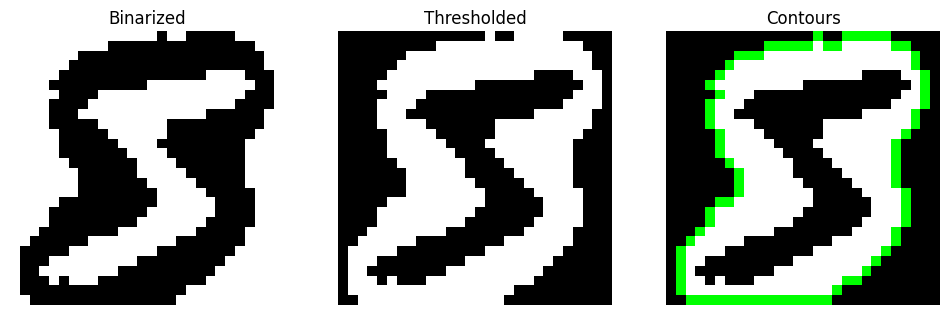

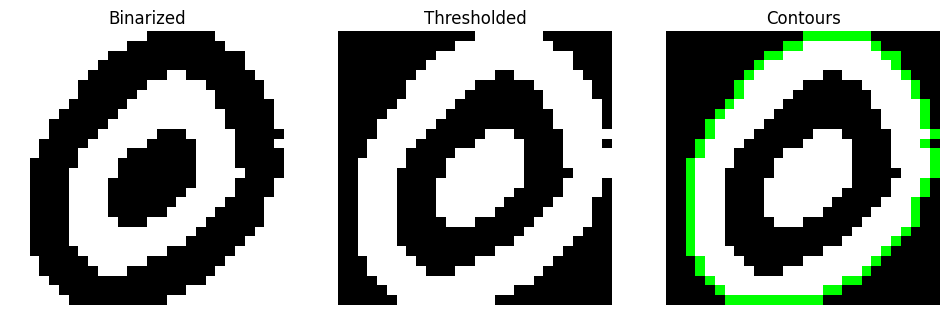

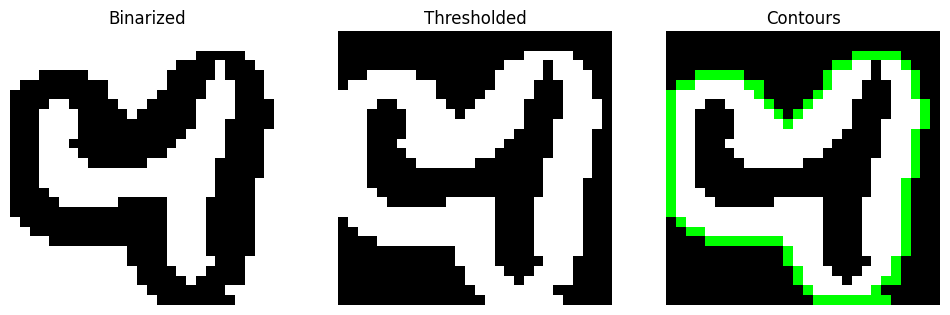

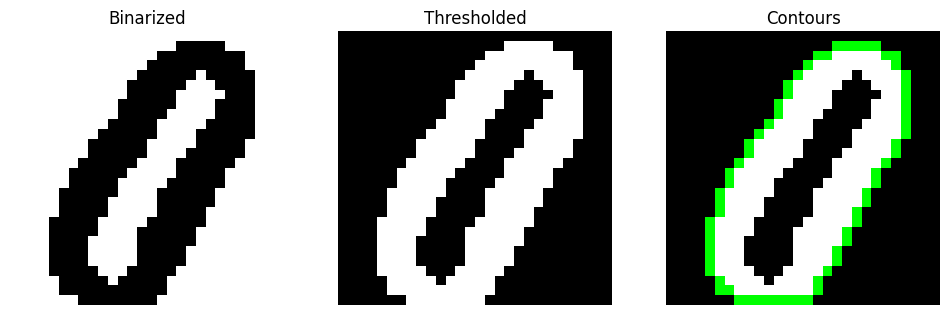

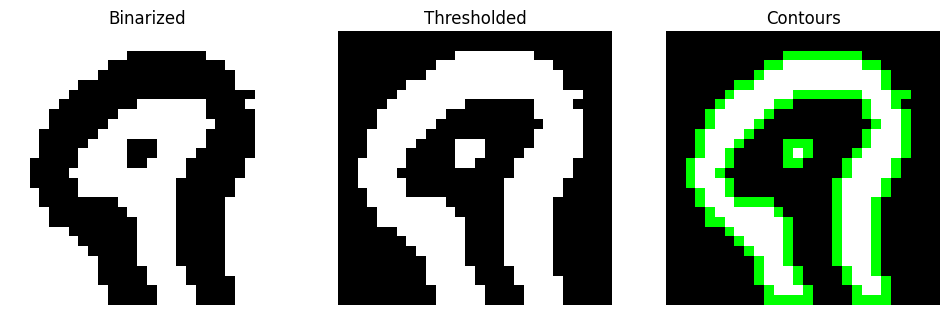

In [20]:
segmented_train_X = []
for i, (_, _, _, img_binarized) in enumerate(restored_train_X[:5]):  # For first 5 images
    binary, img_with_contours, segments = segment_characters(img_binarized)
    segmented_train_X.append(segments)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_binarized, cmap='gray')
    plt.title("Binarized")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap='gray')
    plt.title("Thresholded")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_with_contours)
    plt.title("Contours")
    plt.axis('off')
    plt.show()

# **Feature Extraction using HOG**





In [24]:
def extract_hog_features(images):
    features = []
    for img in images:
        # Reshape the flattened image to its original dimensions
        img = img.reshape(28, 28)  # Assuming original images are 28x28
        feature, _ = hog(
            img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
            block_norm='L2-Hys', visualize=True
        )
        features.append(feature)
    return np.array(features)

In [27]:
flat_train_X = [img.flatten() for img in train_X[:5]]  # Extract HOG for first 5 images
train_features = extract_hog_features(flat_train_X)
print("Sample HOG Features:")
print(train_features[0])  # Print HOG feature vector for the first image

Sample HOG Features:
[0.11467531 0.         0.02290253 0.         0.         0.
 0.         0.         0.         0.         0.         0.11085477
 0.39121772 0.39121772 0.         0.         0.         0.
 0.00717519 0.         0.         0.         0.         0.
 0.         0.         0.12214352 0.18691089 0.11630803 0.14270929
 0.11211995 0.32787854 0.39121772 0.39121772 0.39121772 0.0700344
 0.         0.         0.06999676 0.30878156 0.30878156 0.
 0.         0.         0.         0.0403852  0.05857328 0.27350325
 0.30878156 0.30878156 0.09282951 0.08623284 0.         0.06422312
 0.11802069 0.0734401  0.09011058 0.07079563 0.20703155 0.30878156
 0.30878156 0.30878156 0.04422165 0.04555781 0.13181194 0.
 0.06161783 0.1485084  0.09856407 0.30878156 0.         0.
 0.00547061 0.         0.         0.         0.         0.
 0.         0.         0.09312644 0.14250733 0.08867726 0.1088065
 0.08548412 0.24998593 0.37560603 0.37560603 0.37560603 0.05339664
 0.01671575 0.06664161 0.2771461

In [28]:
flat_train_X = [img.flatten() for img in train_X]  # Extract HOG for all images
train_features = extract_hog_features(flat_train_X)

# **Models**

In [29]:
# Train-Test Split for Model Training
X_train, X_test, y_train, y_test = train_test_split(
    train_features, train_y, test_size=0.2, random_state=42, stratify=train_y
)

# **Random Forest**

In [30]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [31]:
# Evaluate Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1185
           1       0.97      0.98      0.97      1348
           2       0.94      0.97      0.95      1192
           3       0.95      0.91      0.93      1226
           4       0.96      0.96      0.96      1168
           5       0.96      0.95      0.96      1084
           6       0.98      0.98      0.98      1184
           7       0.94      0.92      0.93      1253
           8       0.92      0.93      0.92      1170
           9       0.92      0.93      0.92      1190

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



In [47]:
# Visualization of Predictions
random_indices = np.random.choice(len(y_test), size=10, replace=False)
print("Random Forest Predictions:")
for idx in random_indices:
    print(f"True: {y_test[idx]}, Pred: {rf_predictions[idx]}")


Random Forest Predictions:
True: 0, Pred: 0
True: 0, Pred: 0
True: 7, Pred: 7
True: 8, Pred: 8
True: 8, Pred: 8
True: 7, Pred: 7
True: 5, Pred: 5
True: 2, Pred: 2
True: 1, Pred: 1
True: 6, Pred: 6


# **Logisitic Regression**

In [48]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

In [49]:
# Evaluate Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1185
           1       0.97      0.97      0.97      1348
           2       0.94      0.95      0.94      1192
           3       0.94      0.93      0.93      1226
           4       0.94      0.93      0.94      1168
           5       0.95      0.95      0.95      1084
           6       0.96      0.96      0.96      1184
           7       0.94      0.91      0.92      1253
           8       0.90      0.92      0.91      1170
           9       0.92      0.92      0.92      1190

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



In [50]:
# Visualization of Predictions
random_indices = np.random.choice(len(y_test), size=10, replace=False)
print("Logistic Regression Predictions:")
for idx in random_indices:
    print(f"True: {y_test[idx]}, Pred: {lr_predictions[idx]}")

Logistic Regression Predictions:
True: 9, Pred: 9
True: 3, Pred: 3
True: 6, Pred: 6
True: 7, Pred: 7
True: 7, Pred: 7
True: 2, Pred: 2
True: 2, Pred: 8
True: 0, Pred: 0
True: 8, Pred: 8
True: 8, Pred: 8


# **SVM**

In [51]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

In [52]:
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1185
           1       0.98      0.99      0.99      1348
           2       0.97      0.98      0.97      1192
           3       0.97      0.95      0.96      1226
           4       0.98      0.97      0.97      1168
           5       0.98      0.98      0.98      1084
           6       0.98      0.99      0.98      1184
           7       0.97      0.97      0.97      1253
           8       0.94      0.96      0.95      1170
           9       0.96      0.95      0.96      1190

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



In [53]:
# Visualization of Predictions
random_indices = np.random.choice(len(y_test), size=10, replace=False)
print("SVM Predictions:")
for idx in random_indices:
    print(f"True: {y_test[idx]}, Pred: {svm_predictions[idx]}")


SVM Predictions:
True: 6, Pred: 6
True: 4, Pred: 4
True: 4, Pred: 4
True: 8, Pred: 8
True: 6, Pred: 6
True: 5, Pred: 5
True: 2, Pred: 2
True: 2, Pred: 2
True: 7, Pred: 7
True: 7, Pred: 7


# **Decision Tree**

In [55]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

In [56]:
# Evaluate Decision Tree
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_predictions))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1185
           1       0.94      0.94      0.94      1348
           2       0.81      0.81      0.81      1192
           3       0.75      0.76      0.75      1226
           4       0.81      0.80      0.80      1168
           5       0.82      0.81      0.82      1084
           6       0.87      0.87      0.87      1184
           7       0.83      0.81      0.82      1253
           8       0.73      0.74      0.74      1170
           9       0.77      0.80      0.79      1190

    accuracy                           0.82     12000
   macro avg       0.82      0.82      0.82     12000
weighted avg       0.82      0.82      0.82     12000



In [57]:
# Visualization of Predictions
random_indices = np.random.choice(len(y_test), size=10, replace=False)
print("Decision Tree Predictions:")
for idx in random_indices:
    print(f"True: {y_test[idx]}, Pred: {dt_predictions[idx]}")

Decision Tree Predictions:
True: 1, Pred: 1
True: 0, Pred: 0
True: 5, Pred: 5
True: 6, Pred: 6
True: 1, Pred: 1
True: 9, Pred: 9
True: 0, Pred: 0
True: 9, Pred: 9
True: 1, Pred: 1
True: 5, Pred: 5


# **KNN**

In [58]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

In [59]:
# Evaluate KNN
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, knn_predictions))

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1185
           1       0.97      0.99      0.98      1348
           2       0.98      0.94      0.96      1192
           3       0.93      0.93      0.93      1226
           4       0.97      0.90      0.94      1168
           5       0.97      0.94      0.96      1084
           6       0.96      0.99      0.97      1184
           7       0.96      0.93      0.94      1253
           8       0.91      0.93      0.92      1170
           9       0.88      0.95      0.92      1190

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



In [60]:
# Visualization of Predictions
random_indices = np.random.choice(len(y_test), size=10, replace=False)
print("K-Nearest Neighbors Predictions:")
for idx in random_indices:
    print(f"True: {y_test[idx]}, Pred: {knn_predictions[idx]}")

K-Nearest Neighbors Predictions:
True: 5, Pred: 5
True: 5, Pred: 5
True: 0, Pred: 0
True: 5, Pred: 5
True: 1, Pred: 1
True: 2, Pred: 2
True: 1, Pred: 1
True: 7, Pred: 7
True: 1, Pred: 1
True: 1, Pred: 1
